# Lending club loan Data Analysis and Predictions

In [1]:
# Loading the required Libraries
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from statistics import mode

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

import xgboost as xgb
from scipy.stats import boxcox

import math 
from google.colab import drive 
import os 

## 1. Importing the Data

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [4]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Lending Club')

In [5]:
path = 'data'
Loan = pd.read_csv(path+'/loan.csv', low_memory=False)

In [6]:
Loan.head()

id  member_id  ...  settlement_percentage  settlement_term
0 NaN        NaN  ...                    NaN              NaN
1 NaN        NaN  ...                    NaN              NaN
2 NaN        NaN  ...                    NaN              NaN
3 NaN        NaN  ...                    NaN              NaN
4 NaN        NaN  ...                    NaN              NaN

[5 rows x 145 columns]

##  2. Limit the Feature Space 

#The Full DataSet has 145 Features for each loan. We will select the features in three different ways: 

1. Drop features with more than 75% of missing values. 
2. Check each of the features and see if they arer imporant or not, on the defination given in the lending club data dictionary.
3. Remove all highly correlated features based on the confusion matrix is required. 

## 2.1 Droping Features missing more than 75% of Data 

In [7]:
df= pd.DataFrame({'Count': Loan.isnull().sum(), 'Percent': 100*Loan.isnull().sum()/len(Loan)})
df= df[df['Count'] > 0] 
print(df)

                         Count     Percent
id                     2260668  100.000000
member_id              2260668  100.000000
emp_title               166969    7.385826
emp_length              146907    6.498389
annual_inc                   4    0.000177
...                        ...         ...
settlement_status      2227612   98.537777
settlement_date        2227612   98.537777
settlement_amount      2227612   98.537777
settlement_percentage  2227612   98.537777
settlement_term        2227612   98.537777

[113 rows x 2 columns]


In [8]:
missing_fractions = Loan.isnull().mean().sort_values(ascending=False)

In [9]:
missing_fractions

id                                            1.000000
member_id                                     1.000000
url                                           1.000000
orig_projected_additional_accrued_interest    0.996273
hardship_start_date                           0.995305
                                                ...   
out_prncp_inv                                 0.000000
out_prncp                                     0.000000
initial_list_status                           0.000000
revol_bal                                     0.000000
disbursement_method                           0.000000
Length: 145, dtype: float64

Text(0, 0.5, 'Feature count')

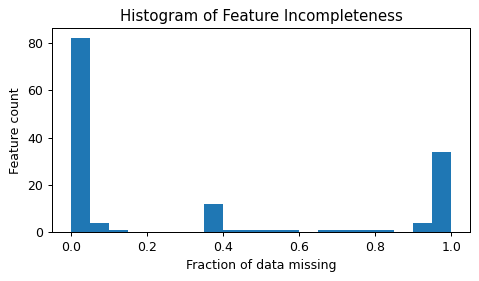

In [10]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above Histogram we see that there is a large gap between some features missing (< 20%) data and those missing of data (> 40%) data.It is very difficult to impute data with more than 75% of missing values,In that case we drop all those columns in our dataset.

In [11]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.75].index))
print(drop_list)

['annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'member_id', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term', 'url', 'verification_status_joint']


How many Features will be dropped?

In [12]:
len(drop_list)

40

Dropping the Features

In [13]:
df1 = Loan
df1.drop(labels = drop_list, axis =1, inplace= True)

In [14]:
df1.shape

(2260668, 105)

## 2.2 Check the Data Defination Dictionary and drop relevant Features

In [15]:
path = 'data'
data_dict = data_dict=pd.read_excel(path+'/LCDataDictionary.xlsx',sheet_name='LoanStats')

In [16]:
data_dict.head()

LoanStatNew                                        Description
0        acc_now_delinq  The number of accounts on which the borrower i...
1  acc_open_past_24mths         Number of trades opened in past 24 months.
2            addr_state  The state provided by the borrower in the loan...
3              all_util              Balance to credit limit on all trades
4            annual_inc  The self-reported annual income provided by th...

In [17]:
data_dtypes=pd.DataFrame(Loan.dtypes,columns=['dtype'])
data_dtypes.reset_index(inplace=True)
data_dtypes.columns=['LoanStatNew', 'dtype']
data_dtypes['first value'] = Loan.loc[0].values

In [18]:
data_dtypes.head()

LoanStatNew    dtype first value
0        loan_amnt    int64        2500
1      funded_amnt    int64        2500
2  funded_amnt_inv  float64        2500
3             term   object   36 months
4         int_rate  float64       13.56

In [19]:
data_col=data_dtypes.merge(data_dict, on='LoanStatNew',how='left')

In [20]:
data_col.head(3)

LoanStatNew  ...                                        Description
0        loan_amnt  ...  The listed amount of the loan applied for by t...
1      funded_amnt  ...  The total amount committed to that loan at tha...
2  funded_amnt_inv  ...  The total amount committed by investors for th...

[3 rows x 4 columns]

In [21]:
d={'LoanStatNew':[],'Nulls':[]}
for i in Loan.columns:
    d['LoanStatNew'].append(i)
    d['Nulls'].append(len(Loan[Loan[i].isnull()][i]))
data_col=data_col.merge(pd.DataFrame(d),on='LoanStatNew')
nulls=pd.DataFrame(d)

In [22]:
data_col.head(3)

LoanStatNew  ... Nulls
0        loan_amnt  ...     0
1      funded_amnt  ...     0
2  funded_amnt_inv  ...     0

[3 rows x 5 columns]

## First Set of features 

In [23]:
data_col[0:25]

LoanStatNew  ...    Nulls
0                loan_amnt  ...        0
1              funded_amnt  ...        0
2          funded_amnt_inv  ...        0
3                     term  ...        0
4                 int_rate  ...        0
5              installment  ...        0
6                    grade  ...        0
7                sub_grade  ...        0
8                emp_title  ...   166969
9               emp_length  ...   146907
10          home_ownership  ...        0
11              annual_inc  ...        4
12     verification_status  ...        0
13                 issue_d  ...        0
14             loan_status  ...        0
15              pymnt_plan  ...        0
16                 purpose  ...        0
17                   title  ...    23325
18                zip_code  ...        1
19              addr_state  ...        0
20                     dti  ...     1711
21             delinq_2yrs  ...       29
22        earliest_cr_line  ...       29
23          inq_last_6mths  ...       30
24  mths_since_last_delinq  ...  1158502

[25 rows x 5 columns]

In [24]:
df1.drop(['mths_since_last_delinq','emp_title'], axis =1,inplace =True)

## Second Set of features 

In [25]:
data_col[25:50]

LoanStatNew  ...    Nulls
25                     open_acc  ...       29
26                      pub_rec  ...       29
27                    revol_bal  ...        0
28                   revol_util  ...     1802
29                    total_acc  ...       29
30          initial_list_status  ...        0
31                    out_prncp  ...        0
32                out_prncp_inv  ...        0
33                  total_pymnt  ...        0
34              total_pymnt_inv  ...        0
35              total_rec_prncp  ...        0
36                total_rec_int  ...        0
37           total_rec_late_fee  ...        0
38                   recoveries  ...        0
39      collection_recovery_fee  ...        0
40                 last_pymnt_d  ...     2426
41              last_pymnt_amnt  ...        0
42                 next_pymnt_d  ...  1303607
43           last_credit_pull_d  ...       73
44   collections_12_mths_ex_med  ...      145
45  mths_since_last_major_derog  ...  1679893
46                  policy_code  ...        0
47             application_type  ...        0
48               acc_now_delinq  ...       29
49                 tot_coll_amt  ...    70276

[25 rows x 5 columns]

In [26]:
df1.drop(['mths_since_last_major_derog','next_pymnt_d'], axis =1,inplace =True)

## Third Set of features 

In [27]:
data_col[50:78]

LoanStatNew  ...    Nulls
50               tot_cur_bal  ...    70276
51               open_acc_6m  ...   866130
52               open_act_il  ...   866129
53               open_il_12m  ...   866129
54               open_il_24m  ...   866129
55        mths_since_rcnt_il  ...   909924
56              total_bal_il  ...   866129
57                   il_util  ...  1068850
58               open_rv_12m  ...   866129
59               open_rv_24m  ...   866129
60                max_bal_bc  ...   866129
61                  all_util  ...   866348
62          total_rev_hi_lim  ...    70276
63                    inq_fi  ...   866129
64               total_cu_tl  ...   866130
65              inq_last_12m  ...   866130
66      acc_open_past_24mths  ...    50030
67               avg_cur_bal  ...    70346
68            bc_open_to_buy  ...    74935
69                   bc_util  ...    76071
70  chargeoff_within_12_mths  ...      145
71               delinq_amnt  ...       29
72        mo_sin_old_il_acct  ...   139071
73      mo_sin_old_rev_tl_op  ...    70277
74     mo_sin_rcnt_rev_tl_op  ...    70277
75            mo_sin_rcnt_tl  ...    70276
76                  mort_acc  ...    50030
77      mths_since_recent_bc  ...    73412

[28 rows x 5 columns]

## Fourth Set of features 

In [28]:
data_col[78:106]

LoanStatNew  ...    Nulls
78            mths_since_recent_inq  ...   295435
79   mths_since_recent_revol_delinq  ...  1520309
80            num_accts_ever_120_pd  ...    70276
81                   num_actv_bc_tl  ...    70276
82                  num_actv_rev_tl  ...    70276
83                      num_bc_sats  ...    58590
84                        num_bc_tl  ...    70276
85                        num_il_tl  ...    70276
86                    num_op_rev_tl  ...    70276
87                    num_rev_accts  ...    70277
88              num_rev_tl_bal_gt_0  ...    70276
89                         num_sats  ...    58590
90                 num_tl_120dpd_2m  ...   153657
91                     num_tl_30dpd  ...    70276
92               num_tl_90g_dpd_24m  ...    70276
93               num_tl_op_past_12m  ...    70276
94                   pct_tl_nvr_dlq  ...    70431
95                 percent_bc_gt_75  ...    75379
96             pub_rec_bankruptcies  ...     1365
97                        tax_liens  ...      105
98                  tot_hi_cred_lim  ...    70276
99                total_bal_ex_mort  ...    50030
100                  total_bc_limit  ...    50030
101      total_il_high_credit_limit  ...    70276
102                   hardship_flag  ...        0
103             disbursement_method  ...        0
104            debt_settlement_flag  ...        0

[27 rows x 5 columns]

In [29]:
df1.shape

(2260668, 101)

## 2.3 Confusion Matrix Creation and Removing most Highly Correlated Features

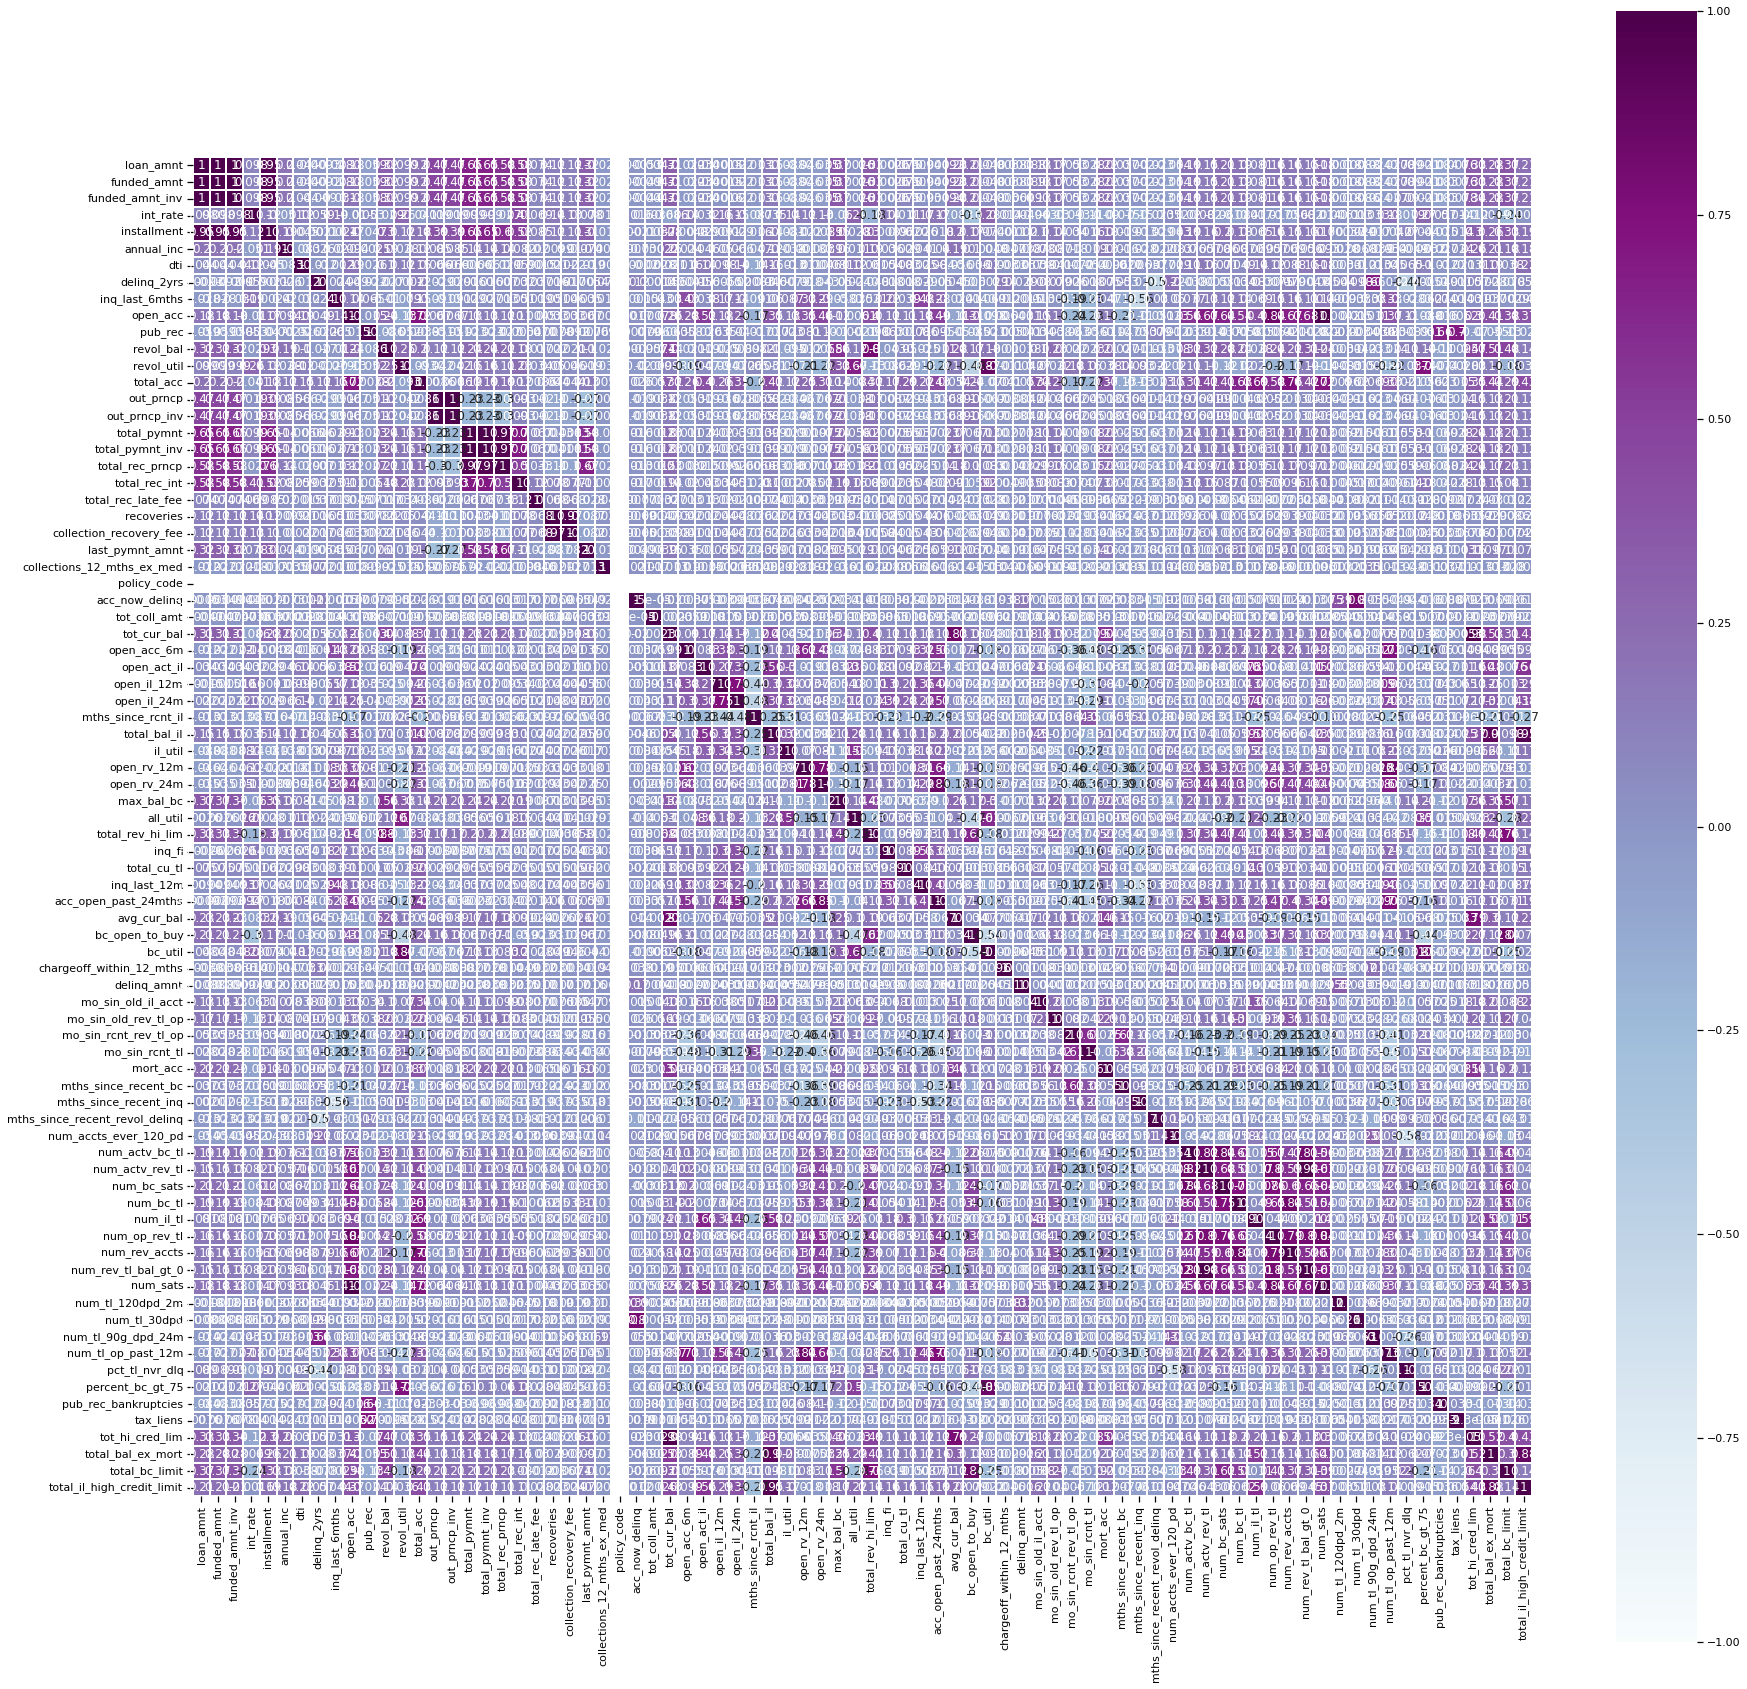

In [30]:
plt.figure(figsize=(30,30))
sns.set_context("notebook", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df1.corr(), annot=True, cmap='BuPu',vmin=-1, vmax=1, square=True, linewidths=1)

In [31]:
df1.drop(['loan_amnt','funded_amnt','funded_amnt_inv','installment','open_acc','out_prncp','out_prncp_inv','total_pymnt',
         'total_pymnt_inv','total_rec_prncp','recoveries','collection_recovery_fee','tot_cur_bal','num_actv_rev_tl',
          'num_rev_tl_bal_gt_0','num_sats',], axis=1,inplace= True)

In [32]:
df1.shape

(2260668, 85)

In [33]:
df1.head()

term  int_rate  ... disbursement_method debt_settlement_flag
0   36 months     13.56  ...                Cash                    N
1   60 months     18.94  ...                Cash                    N
2   36 months     17.97  ...                Cash                    N
3   36 months     18.94  ...                Cash                    N
4   60 months     16.14  ...                Cash                    N

[5 rows x 85 columns]

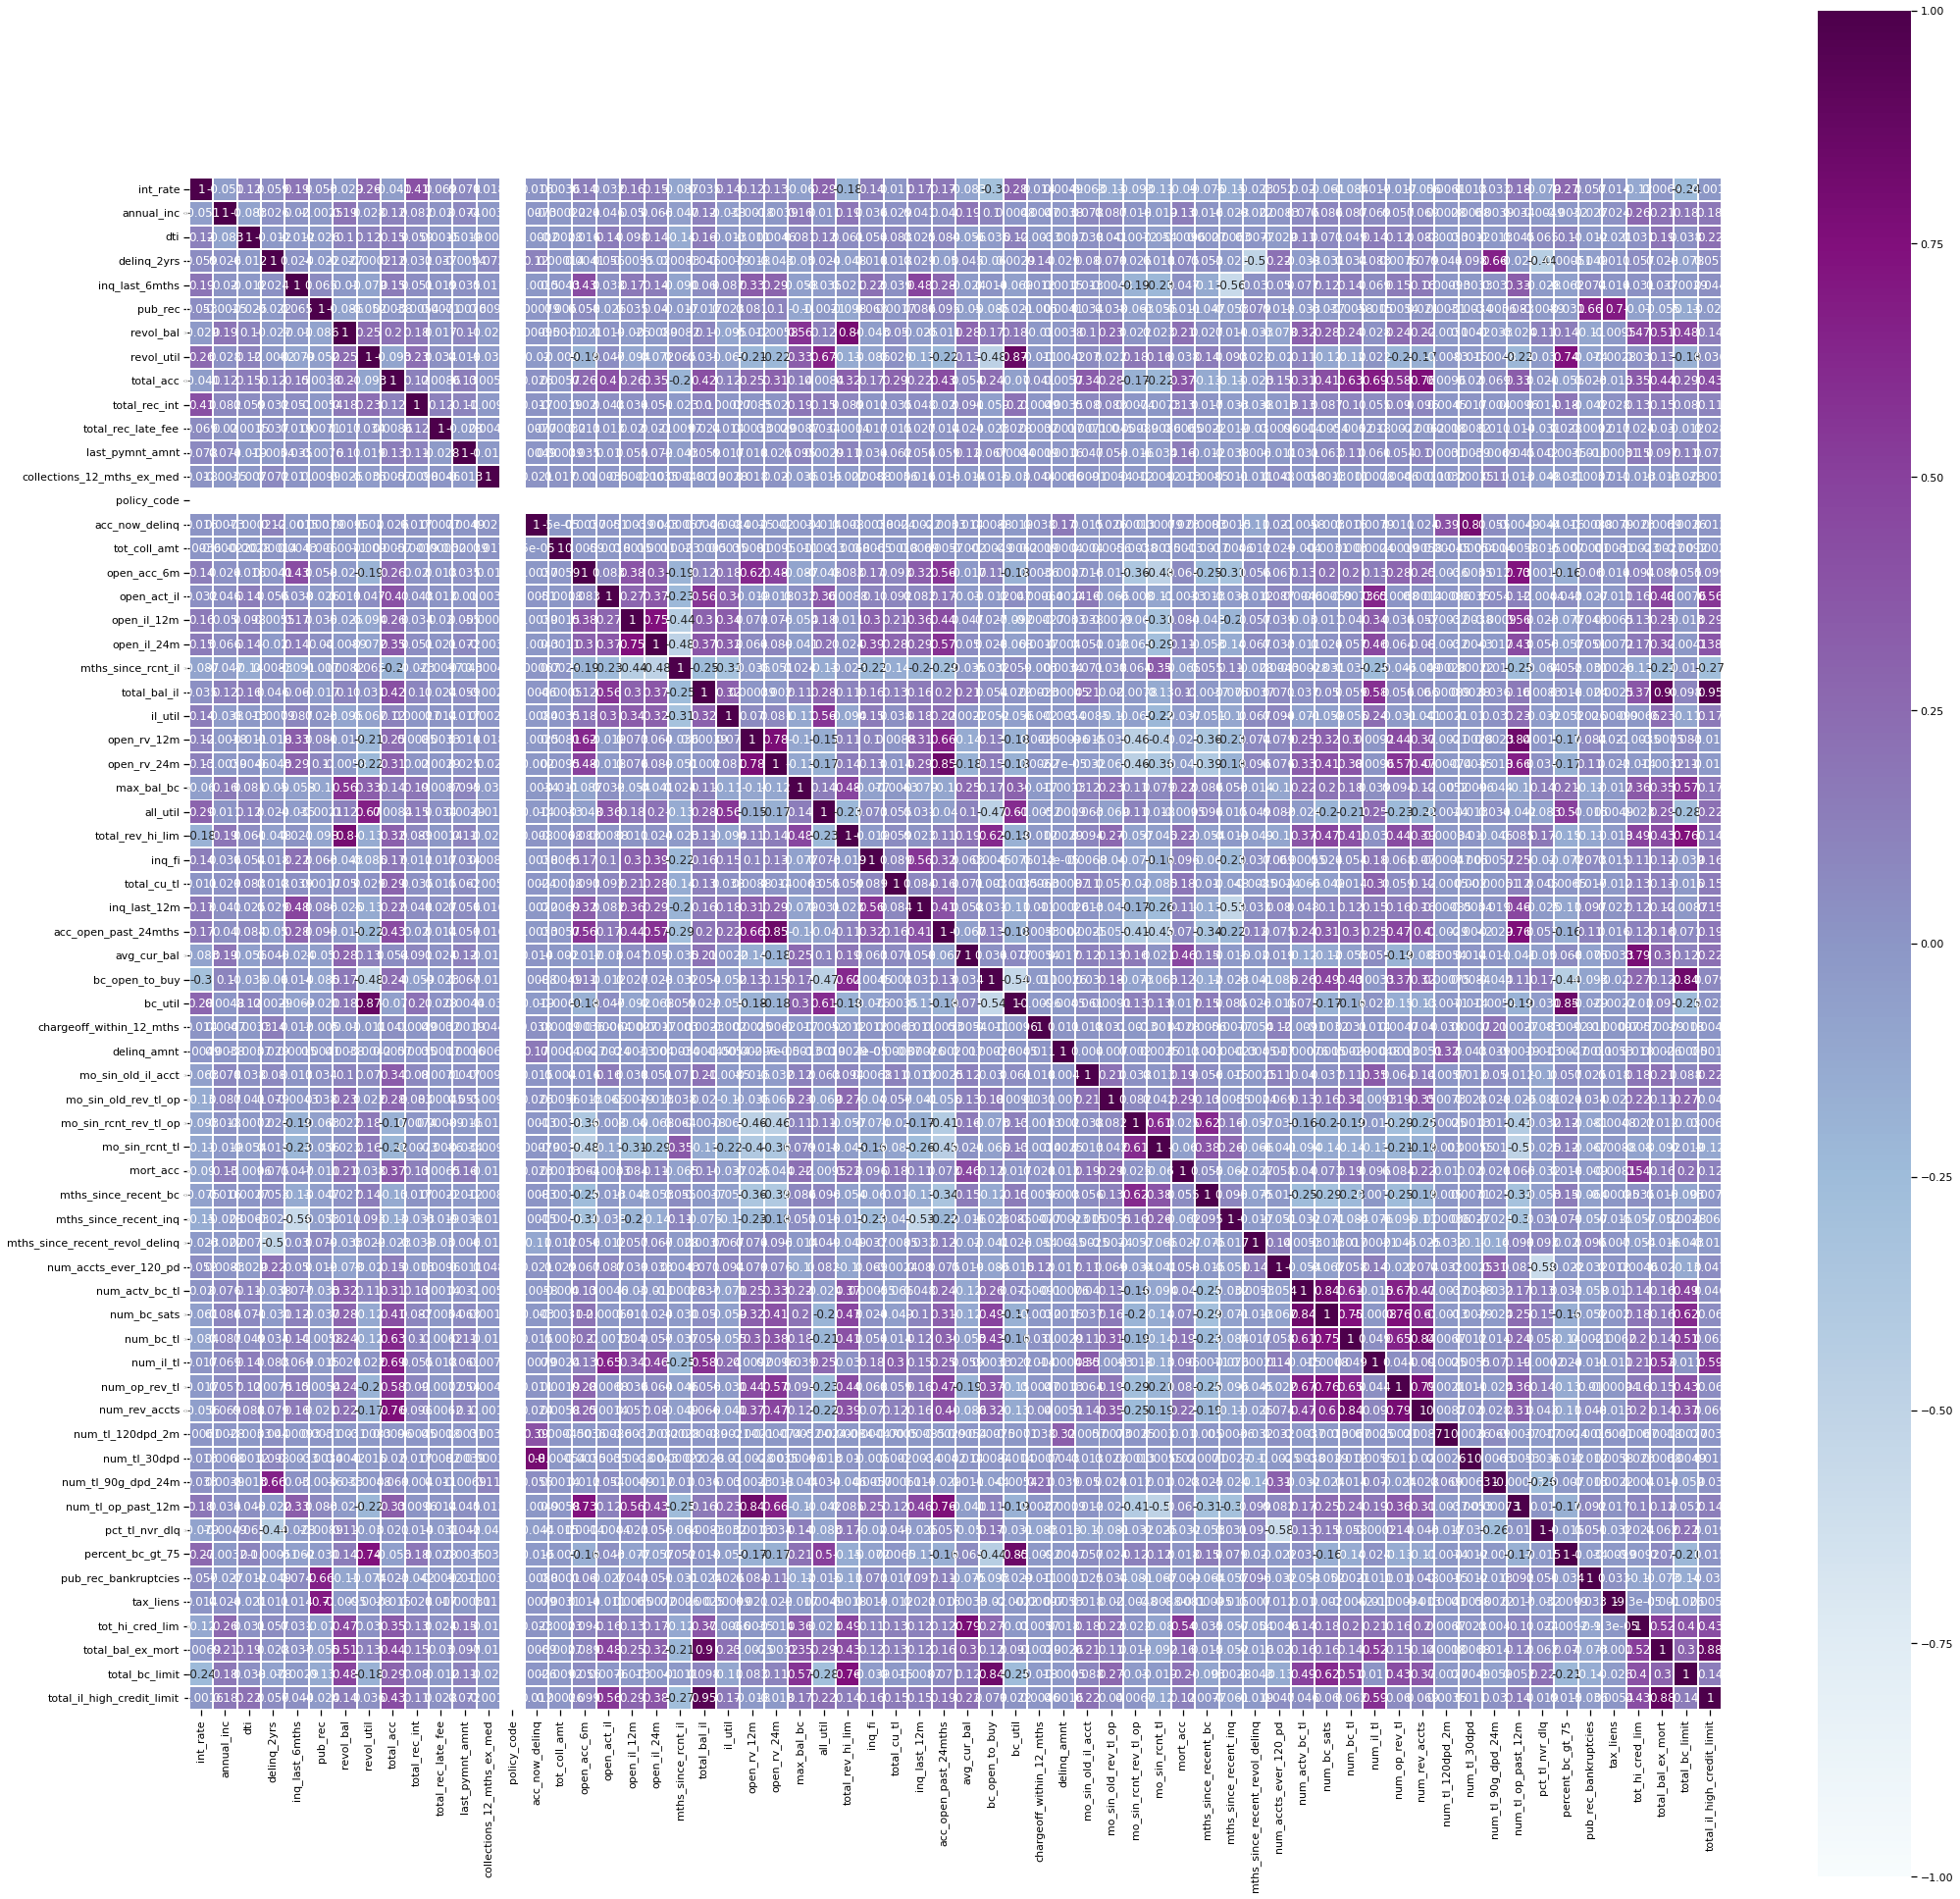

In [34]:
plt.figure(figsize=(35,35))
sns.set_context("notebook", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df1.corr(), annot=True, cmap='BuPu',vmin=-1, vmax=1, square=True, linewidths=1)

In [35]:
df1.drop(['total_bal_il','total_bc_limit','total_il_high_credit_limit'],axis = 1, inplace =True)

In [36]:
df1.shape

(2260668, 82)

In [37]:
df2 = pd.DataFrame({'Count': df1.isnull().sum(), 'Percent': 100*df1.isnull().sum()/len(Loan)})
df2 = df2[df2['Count'] > 0] 
print(df2)

                       Count   Percent
emp_length            146907  6.498389
annual_inc                 4  0.000177
title                  23325  1.031775
zip_code                   1  0.000044
dti                     1711  0.075686
...                      ...       ...
percent_bc_gt_75       75379  3.334368
pub_rec_bankruptcies    1365  0.060380
tax_liens                105  0.004645
tot_hi_cred_lim        70276  3.108639
total_bal_ex_mort      50030  2.213063

[61 rows x 2 columns]


## 3. Pre-processing and Exploratory Analysis
### Strategies
1. Imputation (Mean, Median, etc.): Too expensive computationally, minimal difference on result accuracy.
2. Removing missing values: Miniscule percentage missing, won't adversely effect our models.
3. Converting Numerical Values into Categorical Values and as well as doing One Hot Encoding.

## Fuction Used For Plotting the Features against the Targets and showing Comparision.

In [38]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df1.loc[df1[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df1[col_name], order=sorted(df1[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df1, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = df1.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [39]:
df1=df1.dropna(axis=0)

In [40]:
df1.columns

Index(['term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'total_rec_int', 'total_rec_late_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'm

In [41]:
df1.drop([ 'grade', 'sub_grade','issue_d','zip_code'], axis =1,inplace = True)

In [42]:
df1.drop(["last_credit_pull_d", "earliest_cr_line", "addr_state", "title",'last_pymnt_d','policy_code'], axis=1,inplace = True)

In [43]:
df1.columns

Index(['term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_e

## 3.1 Interest Rate
Data Dictionary: "Interest Rate on the loan."

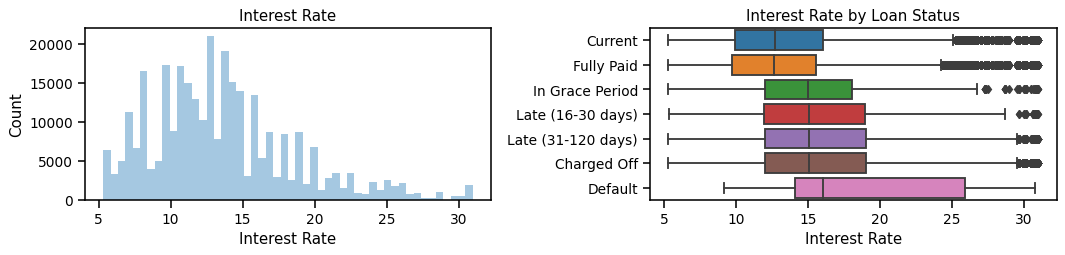

In [44]:
plot_var('int_rate', 'Interest Rate', continuous=True)

## 3.2 Annual Income
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

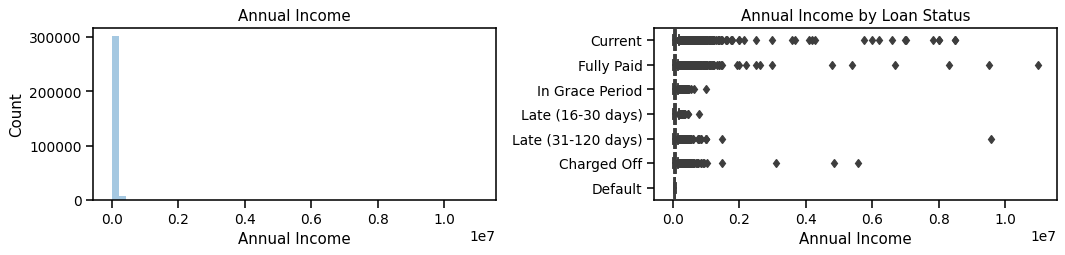

In [45]:
plot_var('annual_inc', 'Annual Income', continuous=True)

## 3.3 Verification Status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

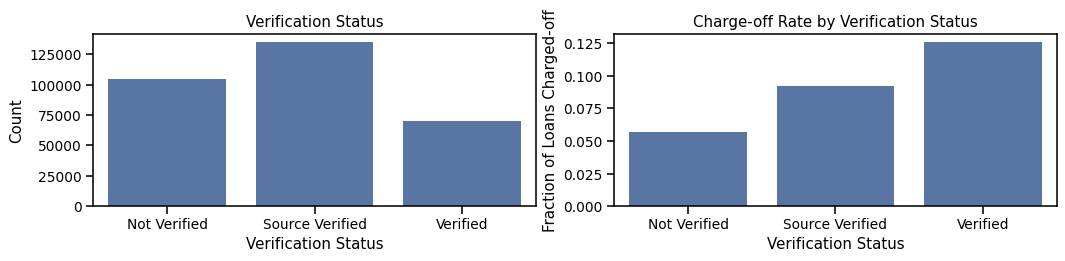

In [46]:
plot_var('verification_status', 'Verification Status', continuous = False)

## 3.4 Purpose
Data Dictionary: "A category provided by the borrower for the loan request."

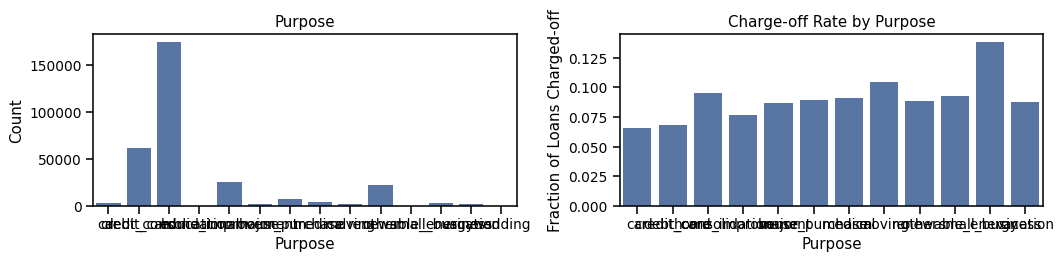

In [47]:
plot_var('purpose', 'Purpose', continuous = False)

## 3.5 Payment Plan
Data Dictionary: "Indicates if a payment plan has been made or not"

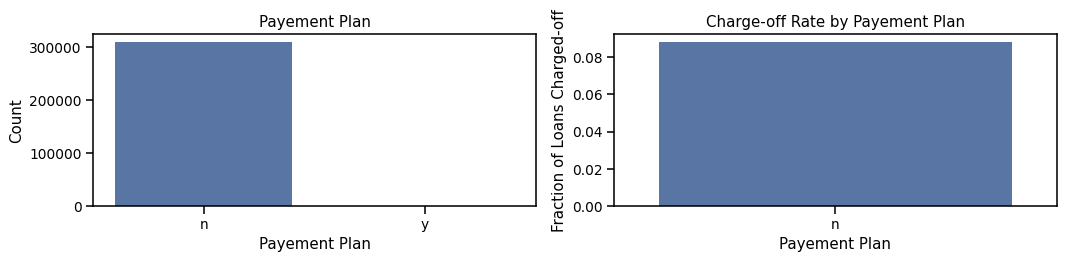

In [48]:
plot_var('pymnt_plan', 'Payement Plan', continuous = False)

## 3.6 Application Type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

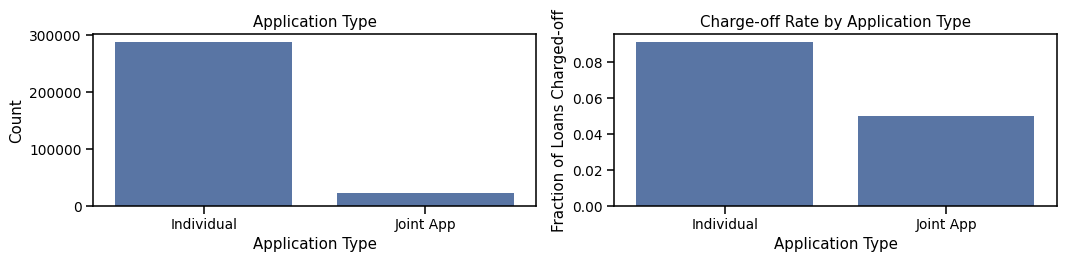

In [49]:
plot_var('application_type', 'Application Type', continuous = False)

## 4 More Preprocessing

## 4.1  Converting the Loan Status to 0 or 1 

In [50]:
df1['loan_status'].unique()

array(['Current', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)',
       'Late (31-120 days)', 'Charged Off', 'Default'], dtype=object)

Plotting the loan Staus

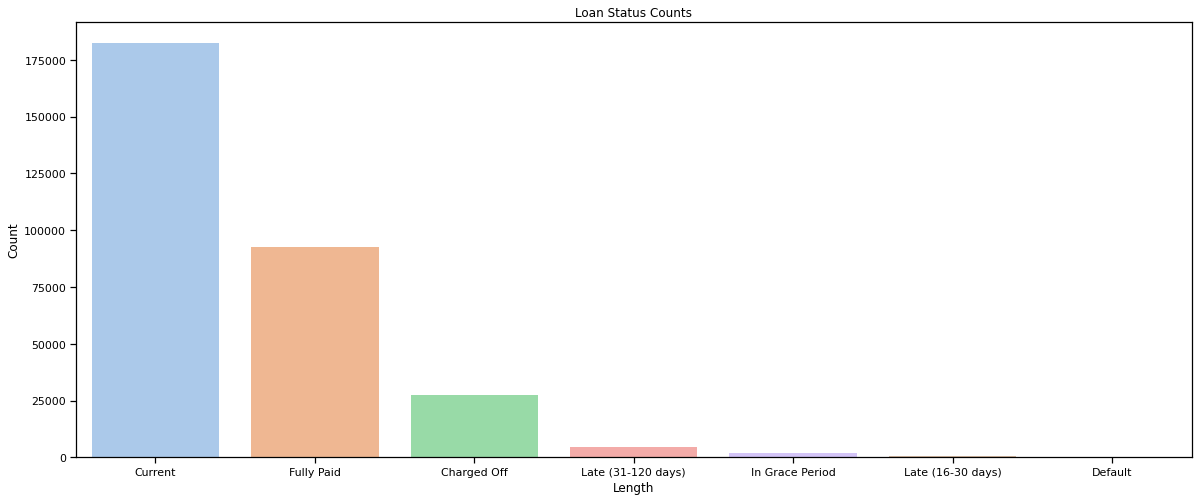

In [51]:
m =df1['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(20,8))
sns.barplot(y='Count', x='Loan Status', data=m, palette="pastel")
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Loan Status Counts")
plt.show()

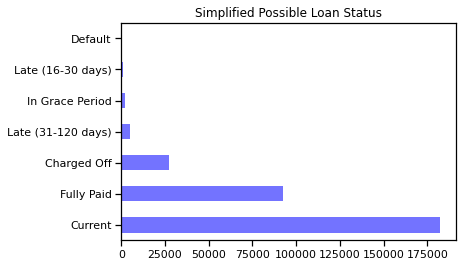

In [52]:
df1['loan_status'].value_counts().plot(kind= 'barh', color = 'blue', title = 'Simplified Possible Loan Status', alpha = 0.55)
plt.show()


In [53]:
df1 = df1[(df1['loan_status'] == "Fully Paid") | (df1['loan_status'] == "Charged Off")]

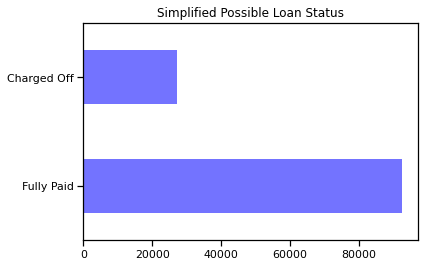

In [54]:
df1['loan_status'].value_counts().plot(kind= 'barh', color = 'blue', title = 'Simplified Possible Loan Status', alpha = 0.55)
plt.show()

In [55]:
status_replace = {
    "loan_status" : {
        "Fully Paid": 1,
        "Charged Off": 0,
    }
}
df1 = df1.replace(status_replace)

## 4.2 One Hot Encoing Based on Exploration Analysis

### Exploration Analysis of few Features

In [56]:
df1['int_rate'] = pd.to_numeric(df1['int_rate'])
df1.dtypes

term                     object
int_rate                float64
emp_length               object
home_ownership           object
annual_inc              float64
                         ...   
tot_hi_cred_lim         float64
total_bal_ex_mort       float64
hardship_flag            object
disbursement_method      object
debt_settlement_flag     object
Length: 72, dtype: object

In [57]:
numerical = df1.columns[df1.dtypes == 'float64']
for i in numerical:
    if df1[i].min() > 0:
        transformed, lamb = boxcox(df1.loc[Loan[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            df1.loc[Loan[i].notnull(), i] = transformed

This is the phase of data cleaning where I am dropping columns by looking at the their decription and the number of null values. As we want to predict loan_status when applicant applies for loan, I have deleted columns which leak information about future. e.g. 'funded_amt', 'last_pymnt_amnt', 'installment', etc.

In [58]:
df3 = df1.select_dtypes(include=["object"])
print(df3.iloc[0])

term                       36 months
emp_length                 10+ years
home_ownership              MORTGAGE
verification_status     Not Verified
pymnt_plan                         n
purpose                  credit_card
initial_list_status                w
application_type           Joint App
hardship_flag                      N
disbursement_method             Cash
debt_settlement_flag               N
Name: 170, dtype: object


In [59]:
df3 = df1.select_dtypes(include=["object"])
print(df3.iloc[0])

term                       36 months
emp_length                 10+ years
home_ownership              MORTGAGE
verification_status     Not Verified
pymnt_plan                         n
purpose                  credit_card
initial_list_status                w
application_type           Joint App
hardship_flag                      N
disbursement_method             Cash
debt_settlement_flag               N
Name: 170, dtype: object


In [60]:
df1.shape

(119819, 72)

In [61]:
null_counts = df1.isnull().sum()
null_counts

term                    0
int_rate                0
emp_length              0
home_ownership          0
annual_inc              0
                       ..
tot_hi_cred_lim         0
total_bal_ex_mort       0
hardship_flag           0
disbursement_method     0
debt_settlement_flag    0
Length: 72, dtype: int64

In [62]:
print(df1.dtypes.value_counts())

float64    59
object     11
int64       2
dtype: int64


In [63]:
df3 = df1.select_dtypes(include=["object"])
print(df3.iloc[0])

term                       36 months
emp_length                 10+ years
home_ownership              MORTGAGE
verification_status     Not Verified
pymnt_plan                         n
purpose                  credit_card
initial_list_status                w
application_type           Joint App
hardship_flag                      N
disbursement_method             Cash
debt_settlement_flag               N
Name: 170, dtype: object


In [64]:
columns = ['term', 'home_ownership', 'verification_status','application_type']
for col in columns:
    print(df1[col].value_counts())
    print(" ")

 36 months    92569
 60 months    27250
Name: term, dtype: int64
 
MORTGAGE    62686
RENT        42823
OWN         14230
ANY            79
NONE            1
Name: home_ownership, dtype: int64
 
Source Verified    54150
Not Verified       34765
Verified           30904
Name: verification_status, dtype: int64
 
Individual    114964
Joint App       4855
Name: application_type, dtype: int64
 


In [65]:
print(df1["purpose"].value_counts())
print (" ")

debt_consolidation    69913
credit_card           21430
home_improvement       9573
other                  8498
major_purchase         2844
medical                1788
small_business         1391
car                    1369
moving                 1035
vacation                997
house                   897
renewable_energy         84
Name: purpose, dtype: int64
 


In [66]:
print(df1['initial_list_status'].value_counts())
print (" ")
print(df1["hardship_flag"].value_counts())
print (" ")
print(df1["debt_settlement_flag"].value_counts())

w    90907
f    28912
Name: initial_list_status, dtype: int64
 
N    119818
Y         1
Name: hardship_flag, dtype: int64
 
N    115873
Y      3946
Name: debt_settlement_flag, dtype: int64


In [67]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}


In [68]:
df1 = df1.replace(mapping_dict)

In [69]:
df1['disbursement_method']

170             Cash
800             Cash
829        DirectPay
930             Cash
1066            Cash
             ...    
2260646         Cash
2260654         Cash
2260655         Cash
2260658         Cash
2260664         Cash
Name: disbursement_method, Length: 119819, dtype: object

## 4.3 Converting Categorical columns into numerical 
The Second phase of Data Cleaning where I am goibg to convert Categorical Columns into Numerical Columns.

In [70]:
categorical_columns = ["home_ownership", "verification_status", "purpose", "term",'pymnt_plan','initial_list_status',
                      'hardship_flag','debt_settlement_flag','disbursement_method','application_type']
dummy_df = pd.get_dummies(df1[categorical_columns])

In [71]:
df1 = pd.concat([df1, dummy_df], axis=1)
df1 = df1.drop(categorical_columns, axis=1)

In [72]:
df1.head()

int_rate  ...  application_type_Joint App
170   2.122115  ...                           1
800   2.724158  ...                           0
829   2.467951  ...                           0
930   2.616890  ...                           0
1066  2.210304  ...                           0

[5 rows x 95 columns]

## 5. Model Evaluation And Validation
Machine Learning Algorithm Fitting

In this part, now that we have cleaned the dataset and encoded the variable with dummy encoding to process categorical data, let's dive in the first machine learning algorithm that we will try to use on the data set. But before, let's see the result of our work on the dataset.

In [73]:
path= 'data'
df1.to_csv(path+'/loan_clean_data.csv', index = False)

In [74]:
Loan.shape

(2260668, 82)